# Notebook 01 - Functions as a Feed Forward Neural Net

No intro for this one - let's pick up where we left off.

Recall our previous function:
$$f(a, b, c) = a * b + c$$

In [2]:
def f(a, b, c):
    return a * b + c

And recall that we can break our function up into smaller parts:
$$mul(a, b) = a * b$$
$$add(ab, c) = ab + c$$
$$f(a, b, c) = add(mul(a, b), c)$$

The function $f$ we defined is a composite function, the combination of multiple functions $g$ and $h$ into a single function
- $mul$ represents multiplication
- $add$ represents addition

This means by using simple functions, we can rewrite complex function as a series of functions taking 2 inputs and producing 1 output.

This also means we can represent our complex function as a graph, with each node taking 2 inputs (children) and 1 output (parent).

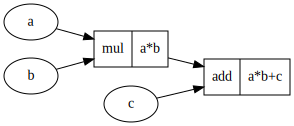

In [3]:
from graphviz import Digraph

dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

# Add our Variables
dot.node(name='a', label='a')
dot.node(name='b', label='b')
dot.node(name='c', label='c')

# Add calculated values
dot.node(name='a*b', label='{mul | a*b}', shape='record')
dot.node(name='a*b+c', label='{add | a*b+c}', shape='record')

# Connect the nodes
dot.edge('a', 'a*b')
dot.edge('b', 'a*b')
dot.edge('a*b', 'a*b+c')
dot.edge('c', 'a*b+c')

# Plot the tree
dot

Quick note that there are also some operations we will use that take just 1 input and produce 1 output. Here's the full list of operations we'll use as the building blocks of our logic:

__2 Inputs, 1 Output:__
1) Addition - $ x + y = z$

2) Multiplication - $ x * y = z$

3) Exponentiation - $ x ^ y = z$

__1 Input, 1 Output:__
1) Natural Exponentiation - $ e ^ y  = z $

2) Natural Log - $ \ln(y) = z$

# Beginnings of a Neural Network - Neurons

Up until now I've purposely avoided any reference to how artificial neural networks are supposed to represent the network of neurons in our brain, primarily because it doesn't (our brains don't use backprop).

However, to build our artificial neural network we need to introduce the concept of a neuron, so I'll lean into the analogy a bit.

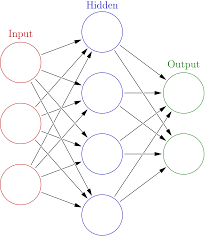

This is the wikipedia image of an artificial neural network. Each circle represents a neuron, and each arrow represents the output of a neuron being fed as an input to another neuron. 

It also looks pretty similar to the graph we produced above - in fact, we can recreate this graph like so:

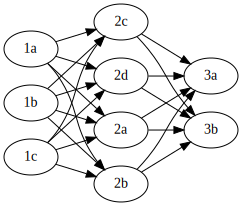

In [4]:
dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

# Add our Variables
l1 = ['1a', '1b', '1c']
dot.node(name='1a', label='1a')
dot.node(name='1b', label='1b')
dot.node(name='1c', label='1c')

l2 = ['2a', '2b', '2c', '2d']
dot.node(name='2a', label='2a')
dot.node(name='2b', label='2b')
dot.node(name='2c', label='2c')
dot.node(name='2d', label='2d')

l3 = ['3a', '3b']
dot.node(name='3a', label='3a')
dot.node(name='3b', label='3b')

# Connect the nodes
for _in in l1:
    for _out in l2:
        dot.edge(_in, _out)
        
for _in in l2:
    for _out in l3:
        dot.edge(_in, _out)

# Plot the tree
dot

__There's a couple things missing here:__
1) We haven't defined what calculations are going on at each step - what's going on?

2) Its a pain to create networks one node and edge at a time - how do we build this?

## What's going on?

The leftmost neurons in our diagram are our inputs, their values are simply propogated to the neurons in next layer.

The middle layer of neurons comprise our hidden layer (hidden layers are everything between the input and the output layers). 

The output of every neuron in the previous layer is fed into every node in the hidden layer, and the output of every neuron in the hidden layer is fed to every neuron in the next layer. This is an example of a Dense Layer, where every neuron in a layer is connected to every neuron in the previous layer.

The rightmost neurons in our diagram are our outputs - they don't flow into other neurons. This is also a dense layer. We'll go into dense layers later but I just wanted to give a taste of how neurons form layers.

## How do we build this?

This is going to be the meat of this notebook and the building block of our entire library. This is also going to be the first piece of code that we'll actually use in the library - __let's code a Scalar__. These scalar values will essentially be what would happen if we "exploded" each one of these neurons into basic binary operations.

- Addition

- Multiplication
    
- Exponentiation

- etc.

Eventually, we'll assemble these scalars into a Directed Acyclic Graph which can built to represent neurons, layers, and finally a complete neural network. 

__Directed Acyclic Graphs (DAGs)__ are a graph built by connecting nodes with directed edges, with the property that there are no cycles formed - meaning that the a node's output will never be used in the calculation of it's input.

For now though, lets focus on building our Scalar class. Each scalar will need to store:
- The value of the scalar
- The inputs used to calculate the value
- The operation used to compute the value

In [5]:
import math

class Scalar:

    def __init__(self, data, _in=(), _op=''):

        self.data = data
        self._prev = set(_in)
        self._op = _op

Let's also add a repr function, which defines the printed representation of our Scalar object.

__Note:__ I'm adding methods to the class in a way that I wouldn't recommend, but I'm doing it this way to avoid having one large block of code. Feel free to reference the GitHub repo for the full code, or piece these together yourself if you'd like.

In [6]:
print(f'Without __repr__(): {Scalar(5)}')

def __repr__(self):
    return f'Scalar(data={self.data})'

Scalar.__repr__ = __repr__ 

print(f'With __repr__():    {Scalar(5)}')

Without __repr__(): <__main__.Scalar object at 0x7fd4b8dcdaf0>
With __repr__():    Scalar(data=5)


We will also need to define our base operations:
- Addition
- Multiplication
- Exponentiation
- Natural Exponentiation
- Natural Log

__Note 1:__ We want to make sure that any calculation between variable values are wrapped in our Scalar class to ensure we can build our graph, which is why we use `isinstance()` for type checking and perform type conversion in the beginning if necessary.

__Note 2:__ You'll notice that the result of every operation isn't a number, but an instance of a Scalar, where we store the result of the calculation, the inputs to the calculation, and the operation used.

__Note 3:__ The reason we define the actual calculation in `_forward()` is because this is used for the forward pass (calculating the output) of our neural network. Eventually, we will also need a backward pass and a `_backward()` counterpart to adjust the weights of the neural network, or "train" the model.

In [7]:
# Addition

def __add__(a, b):

    a = a if isinstance(a, Scalar) else Scalar(a)
    b = b if isinstance(b, Scalar) else Scalar(b)

    # Calculation: y = a + b

    def _forward():
        _a = a.data
        _b = b.data
        _y = _a + _b
        return Scalar(_y, _in=(a, b), _op='+')

    y = _forward()

    return y

Scalar.__add__ = __add__

In [8]:
# Multiplication

def __mul__(a, b):

    a = a if isinstance(a, Scalar) else Scalar(a)
    b = b if isinstance(b, Scalar) else Scalar(b)

    # Calculation: y = a * b

    def _forward():
        _a = a.data
        _b = b.data
        _y = _a * _b
        return Scalar(_y, _in=(a, b), _op='*')
    y = _forward()

    return y

Scalar.__mul__ = __mul__

In [9]:
# Exponentiation

def __pow__(a, b):

    assert isinstance(b, (int, float)), "Exponent is not int/float"

    # Calculation: y = a ** b

    def _forward():
        _a = a.data
        _y = (_a + 1e-8) ** b  # don't divide by 0 kids :)
        return Scalar(_y, _in=(a,), _op=f'**{b}')
    y = _forward()

    return y

Scalar.__pow__ = __pow__

In [10]:
# Natural Exponentiation

def exp(a):

    # Calculation: y = e ** a

    def _forward():
        _a = a.data
        _y = math.exp(_a)
        return Scalar(_y, _in=(a, ), _op='exp')
    y = _forward()

    return y

Scalar.exp = exp

In [11]:
# Natural Log - we add a small epsilon `1e-8` because log(0) is undefined and we want to avoid this.

def log(a):

    # Calculation: y = ln(a)

    def _forward():
        _a = a.data
        _y = math.log(_a + 1e-8)

        return Scalar(_y, _in=(a, ), _op='ln')
    y = _forward()

    return y

Scalar.log = log

Done - You might also be wondering why our binary operators are defined with these "double under" function names, such as `__add__()`

There are a certain set of python function names that are considered __magic methods__ and allow __operator overload__, essentially allowing us to define the way certain symbols (such as +, -, /, \*) work for our class. Here are the ones we will use:

- `__add__(a, b)` -> `a + b`

- `__mul__(a, b)` -> `a * b`

- `__pow__(a, b)` -> `a ** b`

There are a few more that will be introduced.

Just to make a point, if we don't add these to our Scalar class this is what happens:

In [12]:
class WrongScalar:
    
    def __init__(self, data, _in=(), _op=''):

        self.data = data
        self._prev = set(_in)
        self._op = _op
        
WrongScalar(1) + WrongScalar(2)

TypeError: unsupported operand type(s) for +: 'WrongScalar' and 'WrongScalar'

__Here is our scalar class in action:__

In [13]:
Scalar(1) + Scalar(2)

Scalar(data=3)

In [14]:
Scalar(3) * Scalar(2)

Scalar(data=6)

In [15]:
Scalar(3) ** 0

Scalar(data=1.0)

__What if we try to interact with non-Scalar values?__

In [16]:
Scalar(1) + 2

Scalar(data=3)

In [17]:
Scalar(3) * 2

Scalar(data=6)

In [18]:
1 + Scalar(2)

TypeError: unsupported operand type(s) for +: 'int' and 'Scalar'

In [19]:
3 * Scalar(2)

TypeError: unsupported operand type(s) for *: 'int' and 'Scalar'

__wat ?_?__

This happens because when we add or multiply two objects, the method of the left class is used:

When we perform `Scalar(1) + 2`, we are using Scalar addition which has built in type conversion that converts the integer to a Scalar

But when we use `1 + Scalar(2)`, we are using integer addition, which cannot handle our Scalar class.

Luckily, we also have `__radd__`, `__rmul__` - which use the method of the right class if the method of the left class cannot be used, so when we run `1 + Scalar(2)`, integer addition will return a `TypeError`, and Python will try to use Scalar addition.

In [20]:
def __radd__(a, b):

    # b + a = a + b
    return a.__add__(b)

Scalar.__radd__ = __radd__

In [21]:
def __rmul__(a, b):

    # b * a = a * b
    return a.__mul__(b)

Scalar.__rmul__ = __rmul__

and now it works :)

In [22]:
1 + Scalar(2)

Scalar(data=3)

In [23]:
3 * Scalar(2)

Scalar(data=6)

__What about subtraction, division, and negatives?__

We'll add these in too, but this is out of convenience rather than pure necessity (although you'd probably go crazy without them). This is because all these functions can be written as a combination of the methods we've already defined.

Here are the operators:
- `__neg__(a)` -> `-a`
- `__sub__(a, b)` -> `a - b`
- `__truediv__(a, b)` -> `a / b`

In [24]:
def __neg__(a):

    # -a = a * -1
    return a.__mul__(-1)

Scalar.__neg__ = __neg__

In [25]:
def __sub__(a, b):

    # a - b = a + (b * -1)
    return a.__add__(b.__neg__())

def __rsub__(a, b):

    # b - a = (a * -1) + b
    return (a.__neg__()).__add__(b)

Scalar.__sub__ = __sub__
Scalar.__rsub__ = __rsub__

In [26]:
def __truediv__(a, b):

    # a / b = a * (b ** -1)
    return a.__mul__((b + 1e-8).__pow__(-1)) # Avoid Division by 0

def __rtruediv__(a, b):

    # b / a = b * (a ** -1)
    return Scalar(b).__mul__((a + 1e-8).__pow__(-1)) # Avoid Division by 0

Scalar.__truediv__ = __truediv__
Scalar.__rtruediv__ = __rtruediv__

Let's test them out:

In [27]:
-Scalar(3)

Scalar(data=-3)

In [28]:
1 - Scalar(-1)

Scalar(data=2)

In [29]:
Scalar(5) - 6

Scalar(data=-1)

In [30]:
Scalar(21) / 3

Scalar(data=6.9999999766666665)

In [31]:
20 / Scalar(5)

Scalar(data=3.999999984)

__And we're done!__ - these are all the operators we will use in KaiTorch.

Recall our very first function in Notebook 0:
$$f(x) = 2x^2 - 3x + 4$$

Let's recreate this using our new Scalar class, setting $x=3$

In [32]:
x = Scalar(3)

fx = 2*x**2 - 3*x + 4
fx

Scalar(data=13.00000012)

In [33]:
2*3**2 - 3*3 + 4

13

What about our simple multi-variate function?
$$f(a, b, c) = a * b + c$$

In [34]:
a = Scalar(5); a.label = 'a'
b = Scalar(3); b.label = 'b'
c = Scalar(-6); c.label = 'c'

d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
e

Scalar(data=9)

Let's inspect our calculated variables

In [35]:
def inspect(s):
    print(f'The value of {s.label} is {s.data}')
    print(f'Inputs used:')
    for i in s._prev:
        print(f' - {i.label}: {i.data}')
    print(f'Operation used: {s._op}')

In [36]:
inspect(d)

The value of d is 15
Inputs used:
 - a: 5
 - b: 3
Operation used: *


In [37]:
inspect(e)

The value of e is 9
Inputs used:
 - c: -6
 - d: 15
Operation used: +


__nice, everything is connected!__

All that's left is write a function to recursively build out our DAG starting from the output, and working backwards until we've built out our whole function.

If you're not familiar with recursion, it's basically when a function (contains a set of instructions, which includes calling itself at some point) is run until it no longer needs to call itself.

In `trace(root)`, we're initializing sets `nodes` and `edges` to build our graph.

In `build(node)`, we:
- Add `node` to `nodes`
- For each child in `node._prev`:
    - Add the directed edge `(child, node)` to `edges`
    - Call `build(child)`
    
__[note for those who are coding along]__

When `# kaitorch/___.py` is included in a cell, it contains code that is used in the final version of KaiTorch :) You can use this to build your own modules.

In [38]:
# kaitorch/graph.py

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [39]:
nodes, edges = trace(e)
print(f'Nodes: {nodes}')
print(f'Edges: {edges}')

Nodes: {Scalar(data=-6), Scalar(data=3), Scalar(data=9), Scalar(data=5), Scalar(data=15)}
Edges: {(Scalar(data=-6), Scalar(data=9)), (Scalar(data=5), Scalar(data=15)), (Scalar(data=15), Scalar(data=9)), (Scalar(data=3), Scalar(data=15))}


__This is all the information we need for our graph, let's build it out and visualize it!__

In [40]:
def plot_model(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # L to R

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        
        # For every Scalar object, create a node
        dot.node(name=uid, label="{data %.4f | grad %.4f}"%(n.data, n.grad), shape='record')
        
        # If a Scalar is a calculated value (not an input)
        if n._op:
            
            # Create a node representing the operation
            dot.node(name=uid+n._op, label=n._op)
            
            # Draw an edge from the operation to the Scalar
            dot.edge(uid+n._op, uid)

    # For every input to output edge
    for n1, n2 in edges:
        
        # Draw an edge from the input to the operator used to calculate the output
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

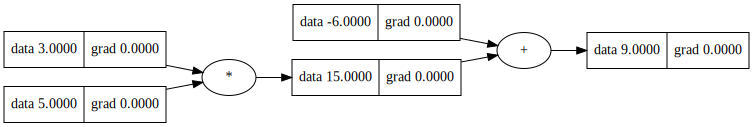

In [41]:
plot_model(e)

__🥳 We've successfully represented the function `a + b * c` as a__ _(very very very simple)_ __Feed Forward Neural Net!__

Ignore `grad` for now - we'll go over that during backprop.

I highly encourage you to use this notebook to build out some more complex functions and check out the DAGs produced.

# Looking Ahead

As a little taste of what's to come, the computation we've performed above is actually what the computation of a neural network with 1 input node and 1 output node would look like.

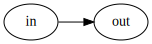

In [42]:
dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

# Add our Variables
dot.node(name='in', label='in')
dot.node(name='out', label='out')

dot.edge('in', 'out')

# Plot the tree
dot

Here's what each variable would represent:

- `a` - Input variable `in`
- `b` - The weight of node `out` that is associated with input `in`
- `c` - The bias of node `out`

The output of each dense node is the dot product of its inputs and weights, with a bias term added. We'll go deeper into this when we code our Dense layer!

#### Little Note:
I hate it when I'm going throgh a tutorial notebook and the code don't match the repo, so I'll try to avoid doing that.

You'll notice the above `plot_model()` function is slightly different from the one in the repo, which is:

In [43]:
# kaitorch/graph.py

def plot_model(root, filename=None):
    dot = Digraph(format='png', graph_attr={'rankdir': 'TB'})

    all_nodes = set()
    all_edges = set()
    
    if not isinstance(root, list):
        root = [root]

    for r in root:
        nodes, edges = trace(r)
        all_nodes = all_nodes.union(nodes)
        all_edges = all_edges.union(edges)
    all_nodes = list(all_nodes)
    all_edges = list(all_edges)

    for n in all_nodes:
        uid = str(id(n))

        dot.node(name=uid,
                 label="{data %.4f | grad %.4f}" % (n.data, n.grad),
                 shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for n1, n2 in all_edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    if filename:
        dot.render(filename=filename, view=True)
    return dot

This is a slight modification of what Andrej Karpathy used in his micrograd tutorial - this is because we eventually implement Multi-class Classification which has multiple output nodes, meaning this function has to handle the case where we have multiple root nodes. We also add the option to render to a file because as you'll see, these networks very quickly become too large to properly view in a small notebook window.

Functionally, it works the same for single output networks.

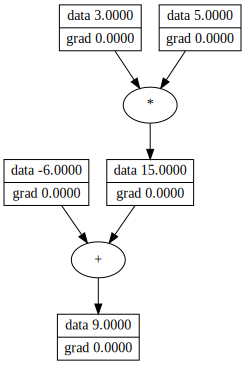

In [45]:
plot_model(e, filename='example')

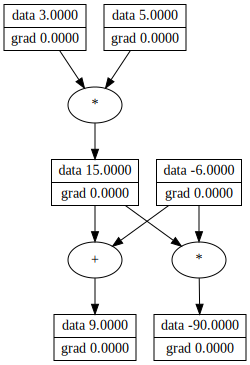

In [46]:
a = Scalar(5); a.label = 'a'
b = Scalar(3); b.label = 'b'
c = Scalar(-6); c.label = 'c'

d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
f = d * c; f.label = 'f'

plot_model([e, f])